In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from Utils import Domain, create_box, calculate_regret, PSGD, estimate_gradient, UniversalAlgorithm
from sklearn.linear_model import LinearRegression

#np.random.seed(42)

Initialing the base parameters for our system. Here, our $f$ is $$f_t(x) = \left(1-\frac{\sin x}{x} \right)\|x\|^2$$
which we see later is strongly convex for $\alpha=.32$. We work over the box $[-1,1]^2$ since any domain in this formalization can be contained in a box, the only change would be extra computation to project each point back into the domain. 


We use larger $T$ to get more information about long-term behavior, seen in the plots. 

In [2]:
#parameters
samples = 21
T = 200
bounday = np.array([[-1,1],[-1,1]])
ext_bounds = np.array([[-2,2],[-2,2]])
domain = create_box(2,int_bounds=bounday,ext_bounds=ext_bounds) 
x0 = np.array([1.5,1.75]) 
f = lambda t,x: (1-np.sin(t)/t) * np.linalg.norm(x)**2 
R = np.sqrt(2)      #domain bound 
G = 4*R            #gradient bound (t term dom by 2, 2x is grad term)
list_str_convex = [PSGD]
list_exp_concave = []
list_convex = [PSGD]

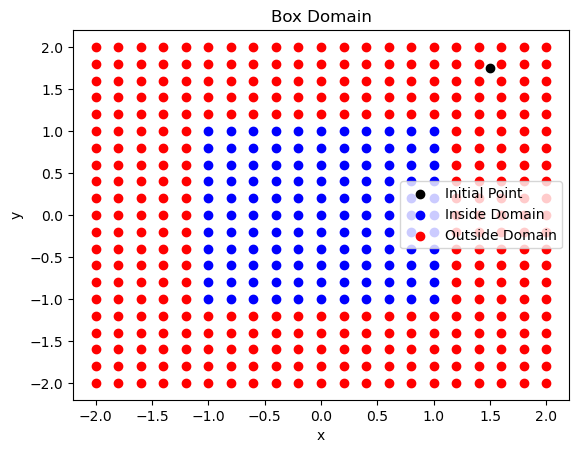

In [3]:
#plotting set up 
plt.figure()
plt.scatter(x0[0],x0[1],color='black',label='Initial Point')
domain.visualize_2dim(num_samples=samples,name='Box Domain')

Since each expert has learning rate $\eta_{t+1} = \frac{1}{\alpha t}$, we can see each expert uses the correct $\alpha$ by checking the learning rate at $t=2$ to account for the shift. 

In [4]:
universal_alg = UniversalAlgorithm(domain=domain,T=T,R=R,G=G,x0=x0,f=f,list_str_convex=list_str_convex,list_exp_concave=list_exp_concave,list_convex=list_convex,samples=samples)

#print parameters for each expert (t=2 is first point since t=1 is initial condition)
print('P_str: ',universal_alg.str_params)
print('eta(2) for each expert:')
for expert in universal_alg.experts:
    print(expert.lr(2.0))

P_str:  [0.005 0.01  0.02  0.04  0.08  0.16  0.32  0.64  1.28 ]
eta(2) for each expert:
200.0
100.0
50.0
25.0
12.5
6.25
3.125
1.5625
0.78125
0.25


In [5]:
avg_regret = []
for t in range(2,T+1):
    universal_alg.run(t)
    if t>20 and t % 5 == 0: 
        reg, opt_point = calculate_regret(f=f,D=domain,x=universal_alg.x[:t],t=t,num_samples=30)
        avg_regret.append([t,reg/t])
        

x = universal_alg.x 

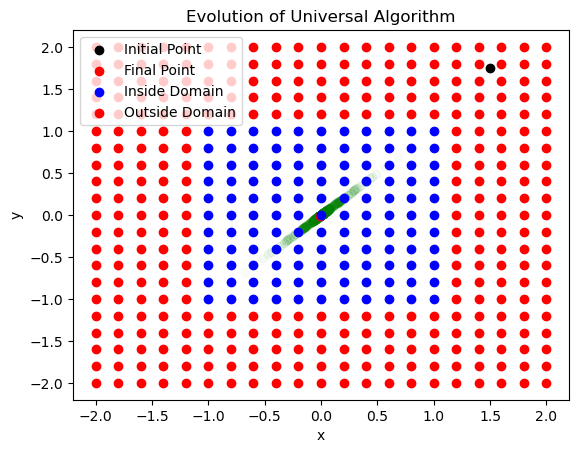

In [6]:
# Plotting set up
plt.figure()
plt.scatter(x[0, 0], x[0, 1], color='black', label='Initial Point')

# Plotting the evolution of the point
for i in range(1, T):
    plt.scatter(x[i, 0], x[i, 1], c='green', alpha=i/t)

#plot final point 
plt.scatter(x[-1, 0], x[-1, 1], color='red', label='Final Point')
domain.visualize_2dim(num_samples=samples,name='Evolution of Universal Algorithm')

To see which experts the algorithm favored, we can sort by the final weight $p$ assigned to each one. Favoring the experts with $\alpha=1.28,.64$ isn't expected behavior, likely because the problem is so simple that stronger guesses are fine too. 

In [7]:
print('Top Experts Ordered by final weight:')
for i in range(9):
    best_expert = np.argsort(universal_alg.p)[universal_alg.E -i-1] 
    if (w:=1/universal_alg.experts[best_expert].lr(2)) == 4:
        print('Convex Expert: ',w, 'weight: ',f'{universal_alg.p[best_expert]:.3f}')
    else:
        print('Strongly Convex Expert: ',w,'weight: ',f'{universal_alg.p[best_expert]:.3f}')

Top Experts Ordered by final weight:
Strongly Convex Expert:  0.64 weight:  0.134
Strongly Convex Expert:  1.28 weight:  0.133
Convex Expert:  4.0 weight:  0.132
Strongly Convex Expert:  0.32 weight:  0.132
Strongly Convex Expert:  0.16 weight:  0.130
Strongly Convex Expert:  0.08 weight:  0.122
Strongly Convex Expert:  0.04 weight:  0.105
Strongly Convex Expert:  0.02 weight:  0.073
Strongly Convex Expert:  0.01 weight:  0.032


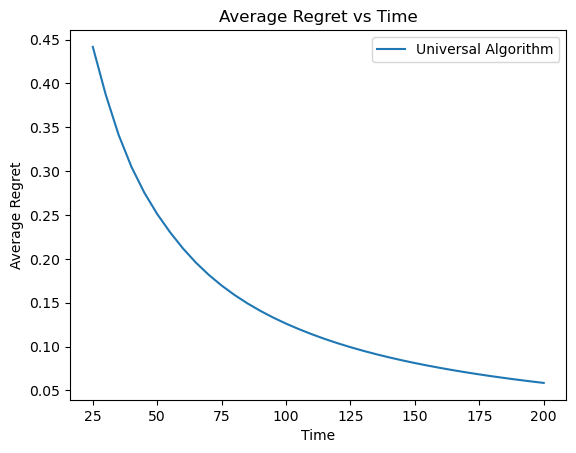

In [8]:
#plotting the regret 
plt.figure()
avg_regret = np.array(avg_regret)
plt.plot(avg_regret[:,0],avg_regret[:,1],label='Universal Algorithm')
plt.xlabel('Time')
plt.ylabel('Average Regret')
plt.title('Average Regret vs Time')
plt.legend()
plt.show()

In [9]:
#find alpha s.t. (1-alpha/2) > sin t / t for all t 
# alpha < 2(1-sin t / t)
# also need alpha > 1/T 

alpha = np.min([2*(1-np.sin(t)/t) for t in range(1,T+1)]) 
assert alpha > 1/T 
print(f'{alpha=:.2f}, {1/T=:.2f}')
eta_strong = lambda t: 1/(alpha*(t-1))
best_expert = PSGD(C=domain,f=f,eta=eta_strong,x0=x0,projection_fn=lambda x: domain.project_point(x,num_samples=samples))

str_avg_regret = []
for t in range(2,T+1):
    best_expert.run(t)
    if t> 20 and t % 5 == 0: 
        reg, opt_point = calculate_regret(f=f,D=domain,x=best_expert.x[:t],t=t,num_samples=30)
        str_avg_regret.append([t,reg/t])

alpha=0.32, 1/T=0.01


Plotting the average regret of the meta-algorithm and the best possible PSGD expert to compare them.

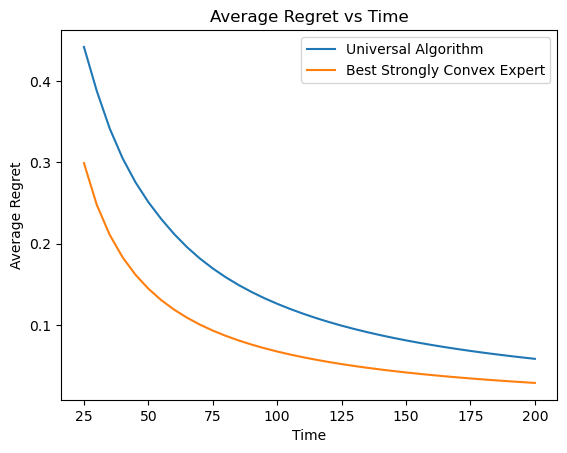

In [10]:
plt.figure()
avg_regret = np.array(avg_regret)
str_avg_regret = np.array(str_avg_regret)
plt.plot(avg_regret[:,0],avg_regret[:,1],label='Universal Algorithm')
plt.plot(str_avg_regret[:,0],str_avg_regret[:,1],label='Best Strongly Convex Expert')
plt.xlabel('Time')
plt.ylabel('Average Regret')
plt.title('Average Regret vs Time')
plt.legend()
plt.show()

Performing a $\log\log$ plot will help us see the trend-line for behavior in that the slope will tell us the approximate power of the average regret decay. 

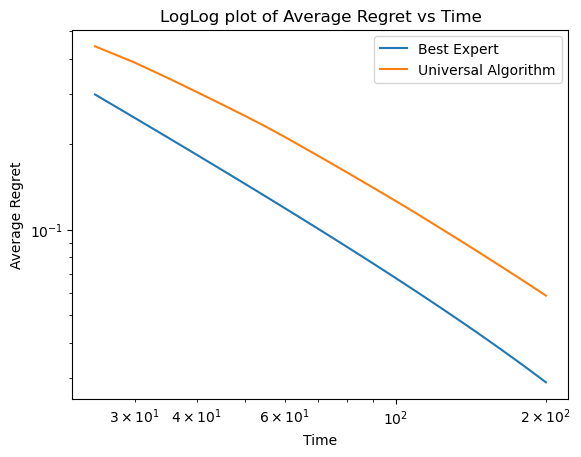

In [11]:
#loglog plot of best expert vs universal algorithm
plt.figure()
str_avg_regret = np.array(str_avg_regret)
plt.loglog(str_avg_regret[:,0],str_avg_regret[:,1],label='Best Expert')
plt.loglog(avg_regret[:,0],avg_regret[:,1],label='Universal Algorithm')
plt.xlabel('Time')
plt.ylabel('Average Regret')
plt.title('LogLog plot of Average Regret vs Time')
plt.legend()
plt.show()

Best Expert Slope:  [[-1.12636608]]
Universal Algorithm Slope:  [[-1.00237672]]


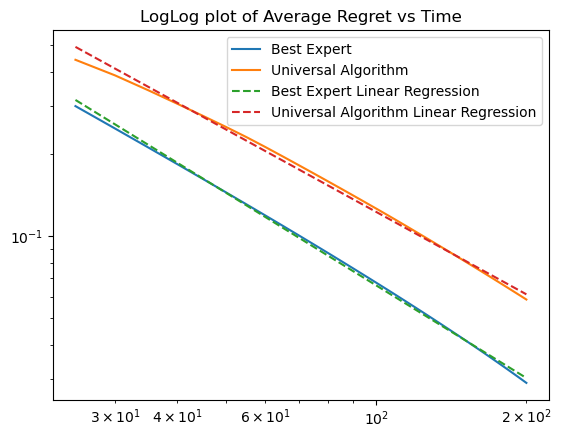

In [12]:
#perform linear regression to analyze the slopes of each line in the loglog plot

X = np.log(str_avg_regret[:,0]).reshape(-1,1)
y = np.log(str_avg_regret[:,1]).reshape(-1,1)
reg = LinearRegression().fit(X,y)
print('Best Expert Slope: ',reg.coef_)
X = np.log(avg_regret[:,0]).reshape(-1,1)
y = np.log(avg_regret[:,1]).reshape(-1,1)
reg2 = LinearRegression().fit(X,y)
print('Universal Algorithm Slope: ',reg2.coef_)

#plot both lines against the loglog plot
plt.figure()
plt.loglog(str_avg_regret[:,0],str_avg_regret[:,1],label='Best Expert')
plt.loglog(avg_regret[:,0],avg_regret[:,1],label='Universal Algorithm')
#plot the linear regression lines
plt.loglog(str_avg_regret[:,0],np.exp(reg.predict(np.log(str_avg_regret[:,0]).reshape(-1,1))),label='Best Expert Linear Regression',linestyle='--')
plt.loglog(avg_regret[:,0],np.exp(reg2.predict(np.log(avg_regret[:,0]).reshape(-1,1))),label='Universal Algorithm Linear Regression',linestyle='--')
plt.title('LogLog plot of Average Regret vs Time')
plt.legend()
plt.show()